In [1]:
##################################
#
# Implementation of the Linear Logic Recurrent Neural Network (LLRNN)
#

###################
# HYPERPARAMETERS #
###################

use_model             = 'ntm' # ntm, pattern_ntm, mult_pattern_ntm
task                  = 'copy' # copy, repeat copy, pattern i, mult pattern i
epoch                 = 100 # number of training epochs, default to 100
num_classes           = 10 # number of symbols, INCLUDING initial and terminal symbols, default 10
N                     = 30 # length of input sequences for training, default to 30, INCLUDING initial and terminal symbols
Ntest                 = 35 # length of sequences for testing, default to 35, INCLUDING initial and terminal symbols
batch_size            = 250 # default 250
controller_state_size = 100 # dimension of the internal state space of the controller, default 100
LOG_DIR               = '/tmp/log' # default /tmp/log
num_training          = 10000 # default 10000
num_test              = num_training
term_symbol           = num_classes - 1
init_symbol           = num_classes - 2
div_symbol            = num_classes - 3

##################
# MODEL SPECIFIC #
##################

ntm_memory_address_size   = 128 # number of memory locations, default 128
ntm_memory_content_size   = 20 # size of vector stored at a memory location, default 20
ntm_powers                = [0,-1,1] # powers of R used by controller, default [0,-1,1]

pattern_ntm_powers               = [[0,-1,1],[0,-1,1]] # powers used by controller on each ring resp.
pattern_ntm_powers_2_on_1        = [0,2,4] # allowed powers used by ring 2 to manipulate ring 1
pattern_ntm_memory_address_sizes = [128, 128] # number of memory locations for the three rings
pattern_ntm_memory_content_sizes = [20, 3] # size of content vector for each ring
pattern_ntm_direct_bias          = 1.0

mult_pattern_ntm_powers               = [[0,-1,1],[0,-1,1],[0,-1,1],[0,-1,1]] # powers used by controller on each ring resp.
mult_pattern_ntm_powers_2_on_1        = [0,1,-1] # allowed powers used by rings 2,3 to manipulate ring 1
mult_pattern_ntm_memory_address_sizes = [128, 20, 20, 10] # number of memory locations for the rings
mult_pattern_ntm_memory_content_sizes = [20, 3, 3, 2] # size of content vector for each ring
mult_pattern_ntm_direct_bias          = 1.0

##########
# NOTES
#
# 1. Always put the zero power first in powers_ring since the code assumes this is there
# 2. The initial and terminal symbols are always from the end of the list of symbols, so they
# are respectively num_classes - 2 and num_classes - 1. So the number of symbols which are
# not initial or terminal is num_classes - 2

In [2]:
%matplotlib inline

# The next three lines are recommend by TF
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
import pandas
import collections
import six
import math
import time
import random

from tensorflow.python.ops.rnn_cell_impl import _RNNCell as RNNCell
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import init_ops
from tensorflow.python.ops.math_ops import sigmoid
from tensorflow.python.ops.math_ops import tanh

# Our libraries
import ntm
import seqhelper
import learnfuncs

assert use_model == 'ntm' or use_model == 'pattern_ntm' or use_model == 'mult_pattern_ntm'

In [3]:
#######################
# SETUP TASKS
#
# Our sequences are of one-hot vectors, which we interpret as follows:
#
# [1.0, 0.0, 0.0] = 0
# [0.0, 1.0, 0.0] = 1
# [0.0, 0.0, 1.0] = 2 etc
#
# We write our sequences and functions referring to sequences of integers,
# and then convert to one-hot vectors for integration with TF.

# Below N_out and Ntest_out are the lengths of the outputs in both the training
# and testing regimes respectively. Since outputs do not include the initial and terminal
# symbols, these default to N - 2 and Ntest - 2 respectively.

# Default sampling from space of inputs
def generate_input_seq_default(max_symbol,input_length):
    return [random.randint(0,max_symbol) for k in range(input_length)]

generate_input_seq = generate_input_seq_default

###########
# COPY TASK
if( task == 'copy' ):
    func_to_learn = learnfuncs.f_identity
    N_out = N - 2
    Ntest_out = Ntest - 2
    seq_length_min = 4

##################
# REPEAT COPY TASK
# put n zeros before the 1, for a copy task with n + 1 copies
if( task == 'repeat copy' ):
    no_of_copies = 2
    pattern = [0]*(no_of_copies - 1) + [1]
    func_to_learn = lambda s: learnfuncs.f_repetitionpattern(s,pattern)
    N_out = no_of_copies * (N - 2)
    Ntest_out = no_of_copies * (Ntest - 2)
    seq_length_min = 4
    
################
# PATTERN TASK 1
if( task == 'pattern 1' ):
    # WARNING: for this task make sure seq_lengh_min is at least 4
    pattern = [0,1,1] # so (a,b,c,d,e,f,...) goes to (a,a,b,c,c,d,e,e,...)
    func_to_learn = lambda s: learnfuncs.f_repetitionpattern(s,pattern)
    N_out = (N - 2) + divmod(N - 2, 2)[0] # N - 2 plus the number of times 2 divides N - 2
    Ntest_out = (Ntest - 2) + divmod(Ntest - 2, 2)[0]
    seq_length_min = 4
    
################
# PATTERN TASK 2
if( task == 'pattern 2' ):
    # WARNING: for this task make sure seq_lengh_min is at least 4
    pattern = [0,2] # so (a,b,c,d,e,f,...) goes to (a,a,c,c,e,e,...)
    func_to_learn = lambda s: learnfuncs.f_repetitionpattern(s,pattern)
    N_out = N - 2 + divmod(N - 2, 2)[0]
    Ntest_out = Ntest - 2 + divmod(Ntest - 2, 2)[0]
    seq_length_min = 4
    
################
# PATTERN TASK 3
if( task == 'pattern 3' ):
    # WARNING: for this task make sure seq_lengh_min is at least 4
    pattern = [0,2,-1] # so (a,b,c,d,e,f,...) goes to (a,a,c,b,b,d,c,c,e,d,d,...)
    func_to_learn = lambda s: learnfuncs.f_repetitionpattern(s,pattern)
    N_out = 4 + (N - 2 - 2) * 3
    Ntest_out = 4 + (Ntest - 2 - 2) * 3
    seq_length_min = 4

################
# PATTERN TASK 4
if( task == 'pattern 4' ):
    # WARNING: for this task make sure seq_lengh_min is at least 4
    pattern = [0,2,1,2,-2,-1] # so (a,b,c,d,e,f,...) goes to (a,a,c,d,f,d,c,c,e,f,h,f,e,e,...)
    func_to_learn = lambda s: learnfuncs.f_repetitionpattern(s,pattern)
    N_out = len(func_to_learn([0]*(N-2)))
    Ntest_out = len(func_to_learn([0]*(Ntest-2)))
    seq_length_min = 4

################
# PATTERN TASK 5
if( task == 'pattern 5' ):
    # WARNING: for this task make sure seq_lengh_min is at least 4
    pattern = [4,1,1,-4] # so (a,b,c,d,e,f,...) goes to (a,e,f,g,k,...)
    func_to_learn = lambda s: learnfuncs.f_repetitionpattern(s,pattern)
    N_out = len(func_to_learn([0]*(N-2)))
    Ntest_out = len(func_to_learn([0]*(Ntest-2)))
    seq_length_min = 4

#########################
# MULTIPLE PATTERN TASK 1
if( task == 'mult pattern 1' or task == 'mult pattern 2'):
    pattern1 = [1] # so (a,b,c,d,e,f,...) goes to (a,b,c,d,e,f,...)
    pattern2 = [0,1] # so (a,b,c,d,e,f,...) goes to (a,a,b,b,...)
    func_to_learn = lambda s: learnfuncs.f_multpattern(s,pattern1,pattern2,div_symbol)
    N_out = 2*(N-2)
    Ntest_out = 2*(Ntest-2)
    seq_length_min = 4
    
#########################
# MULTIPLE PATTERN TASK 2
if( task == 'mult pattern 2' ):
    # Almost everything is the same as mult pattern 1, but in pattern 2 we 
    # make sure there is a div symbol somewhere in the sequence
    def generate_input_seq_forcediv(max_symbol,input_length):
        t = [random.randint(0,max_symbol) for k in range(input_length)]
        div_pos = random.randint(0,len(t)-1)
        t[div_pos] = div_symbol
        return t
    
    generate_input_seq = generate_input_seq_forcediv

# Give an example input/output pair
a = [random.randint(0,num_classes-3) for i in range(N - 2)]
fa = func_to_learn(a)

print("Under the chosen function, the sequence")
print(a)
print("is mapped to")
print(fa)

Under the chosen function, the sequence
[4, 6, 4, 7, 4, 3, 6, 7]
is mapped to
[4, 6, 4, 4, 3, 3, 6, 6]


In [4]:
####################
# INITIALISE STATE #
####################

one_hots = seqhelper.one_hot_vectors(num_classes)
input_size = num_classes # dimension of the input space I

#####
# NTM

def init_state_ntm(batch_size, css, mas, mcs):
    state_size = css + 2*mas + mas * mcs
    
    ra = [0.0]*mas
    ra[0] = 1.0
    batch_address = np.zeros([batch_size,mas]) + ra
    
    init_controller_state = tf.truncated_normal([batch_size, css], 0.0, 1e-6, dtype=tf.float32)    
    init_read_address = tf.constant(batch_address,dtype=tf.float32,shape=[batch_size,mas]) #+ tf.random_uniform([batch_size, mas], 0.0, 1e-6)
    init_write_address = tf.constant(batch_address,dtype=tf.float32,shape=[batch_size,mas]) #+ tf.random_uniform([batch_size, mas], 0.0, 1e-6)
    init_memory = tf.truncated_normal([batch_size, mas*mcs], 0.0, 1e-6, dtype=tf.float32)
    
    state = tf.concat([init_controller_state,init_read_address,init_write_address,init_memory],1)
    return state_size, state

if( use_model == 'ntm' ):
    state_size, state = init_state_ntm(batch_size, controller_state_size, ntm_memory_address_size, ntm_memory_content_size)
    cell = ntm.NTM(state_size,input_size,controller_state_size,ntm_memory_address_size,ntm_memory_content_size, ntm_powers)

#############
# PATTERN NTM

def init_state_pattern_ntm(batch_size, css, mas, mcs):
    # mas and mcs are arrays of address sizes and content sizes for rings
    state_size = css
    
    init_address = []
    
    for i in range(len(mas)):
        state_size = state_size + mas[i] * mcs[i] # for memory vector
        state_size = state_size + 2 * mas[i] # for addresses (read and write)
    
        ra = [0.0]*mas[i]
        ra[0] = 1.0
        init_address.append(np.zeros([batch_size,mas[i]]) + ra)
    
    init_controller_state = tf.truncated_normal([batch_size, css], 0.0, 1e-6, dtype=tf.float32)    
    
    tensor_list = [init_controller_state]
    
    for i in range(len(mas)):
        init_read_address = tf.constant(init_address[i],dtype=tf.float32,shape=[batch_size,mas[i]])
        init_write_address = tf.constant(init_address[i],dtype=tf.float32,shape=[batch_size,mas[i]])
        tensor_list = tensor_list + [init_read_address,init_write_address]
        
    for i in range(len(mas)):
        # The first ring is initialised to zero, the rest differently
        if( i == 0 ):
            init_memory = tf.truncated_normal([batch_size, mas[i]*mcs[i]], 0.0, 1e-6, dtype=tf.float32)
        else:
            ra = [0.0]*mcs[i] 
            ra[0] = 1.0
            ra = np.zeros([batch_size,mas[i],mcs[i]]) + ra
            ra = tf.constant(ra,dtype=tf.float32,shape=[batch_size,mas[i],mcs[i]])
            ra = tf.reshape(ra,[batch_size,mas[i]*mcs[i]])
            init_memory = tf.truncated_normal([batch_size, mas[i]*mcs[i]], 0.0, 1e-6, dtype=tf.float32) + ra
            #init_memory = tf.truncated_normal([batch_size, mas[i]*mcs[i]], 0.0, 1e-6, dtype=tf.float32)
            
        tensor_list = tensor_list + [init_memory]
    
    state = tf.concat(tensor_list,1)

    return state_size, state

if( use_model == 'pattern_ntm' ):
    state_size, state = init_state_pattern_ntm(batch_size, controller_state_size, pattern_ntm_memory_address_sizes, 
                                               pattern_ntm_memory_content_sizes)
    cell = ntm.PatternNTM(state_size, input_size, controller_state_size, pattern_ntm_memory_address_sizes,
                          pattern_ntm_memory_content_sizes, pattern_ntm_powers, pattern_ntm_powers_2_on_1, pattern_ntm_direct_bias)

######################
# MULTIPLE PATTERN NTM

if( use_model == 'mult_pattern_ntm' ):
    state_size, state = init_state_pattern_ntm(batch_size, controller_state_size, mult_pattern_ntm_memory_address_sizes, 
                                               mult_pattern_ntm_memory_content_sizes)
    cell = ntm.MultPatternNTM(state_size, input_size, controller_state_size, mult_pattern_ntm_memory_address_sizes,
                          mult_pattern_ntm_memory_content_sizes, mult_pattern_ntm_powers, mult_pattern_ntm_powers_2_on_1, 
                              mult_pattern_ntm_direct_bias)
    

In [5]:
################
# DEFINE MODEL #
################

inputs = [tf.placeholder(tf.float32, [None,input_size]) for _ in range(N + N_out)]
targets = [tf.placeholder(tf.float32, [None,input_size]) for _ in range(N + N_out)]

# Used in order to flag that we share weights across iterations.
# Note that the training and test phases use all the same weights.
reuse = False

# Set up training graph
read_addresses = []
read_addresses2 = []
read_addresses3 = []
read_addresses4 = []
write_addresses = []
write_addresses2 = []
write_addresses3 = []
write_addresses4 = []
interps = []
rnn_outputs = []
m2 = []
m3 = []
m4 = []
    
for i in range(N + N_out):
    # Logging
    if( use_model == 'ntm' ):
        h0, curr_read, curr_write, _ = tf.split(state, [controller_state_size,ntm_memory_address_size,
                                                        ntm_memory_address_size,-1], 1)

    if( use_model == 'pattern_ntm' ):
        mas = pattern_ntm_memory_address_sizes
        mcs = pattern_ntm_memory_content_sizes
        
        ret = tf.split(state, [controller_state_size,mas[0],mas[0],mas[1],mas[1],mas[0] * mcs[0],mas[1] * mcs[1]], 1)
        
        h0 = ret[0]
        curr_read = ret[1]
        curr_write = ret[2]
        curr_read2 = ret[3]
        curr_write2 = ret[4]
        m1_state = ret[5]
        m2_state = ret[6]
        
    if( use_model == 'mult_pattern_ntm' ):
        mas = mult_pattern_ntm_memory_address_sizes
        mcs = mult_pattern_ntm_memory_content_sizes
        
        ret = tf.split(state, [controller_state_size,mas[0],mas[0],mas[1],mas[1],                        
                            mas[2],mas[2],mas[3],mas[3],mas[0] * mcs[0],mas[1] * mcs[1],
                            mas[2] * mcs[2],mas[3] * mcs[3]], 1)
        
        h0 = ret[0]
        curr_read = ret[1]
        curr_write = ret[2]
        curr_read2 = ret[3]
        curr_write2 = ret[4]
        curr_read3 = ret[5]
        curr_write3 = ret[6]
        curr_read4 = ret[7]
        curr_write4 = ret[8]
        m1_state = ret[9]
        m2_state = ret[10]
        m3_state = ret[11]
        m4_state = ret[12]

    #### RUN MODEL ####
    output, state = cell(inputs[i],state,'NTM',reuse)
    rnn_outputs.append(output)
    ###################
    
    # More logging
    read_addresses.append(curr_read[0,:])
    write_addresses.append(curr_write[0,:])
    
    if( use_model == 'pattern_ntm' or use_model == 'mult_pattern_ntm'):
        read_addresses2.append(curr_read2[0,:])
        write_addresses2.append(curr_write2[0,:])
        m2_state = tf.reshape(m2_state, [-1,mas[1],mcs[1]])
        m2.append(tf.nn.softmax(m2_state[0,:]))
        
        with tf.variable_scope("NTM",reuse=True):
            W_interp = tf.get_variable("W_interp", [controller_state_size,1])
            B_interp = tf.get_variable("B_interp", [1])
            interp = tf.sigmoid(tf.matmul(h0,W_interp) + B_interp)
            interp_matrix = tf.concat([interp,tf.ones_like(interp,dtype=tf.float32) - interp],axis=1) # shape [-1,2]
            interps.append(interp_matrix[0,:])
        
    if( use_model == 'mult_pattern_ntm'):
        read_addresses3.append(curr_read3[0,:])
        write_addresses3.append(curr_write3[0,:])
        read_addresses4.append(curr_read4[0,:])
        write_addresses4.append(curr_write4[0,:])
        m3_state = tf.reshape(m3_state, [-1,mult_pattern_ntm_memory_address_sizes[2],mult_pattern_ntm_memory_content_sizes[2]])
        m3.append(tf.nn.softmax(m3_state[0,:]))
        m4_state = tf.reshape(m4_state, [-1,mult_pattern_ntm_memory_address_sizes[3],mult_pattern_ntm_memory_content_sizes[3]])
        m4_state = m4_state[0,:]
        m4_state = tf.nn.softmax(tf.concat([m4_state,tf.zeros([mult_pattern_ntm_memory_address_sizes[3],1])],1))
        m4.append(m4_state)

    reuse = True

# Final fully connected layer
with tf.variable_scope("final_layer"):
    E = tf.get_variable("E",[controller_state_size,input_size])
    F = tf.get_variable("F",[input_size],initializer=init_ops.constant_initializer(0.0))

# Note: prediction is a length N list of tensors of shape [None,input_size], where
# the jth row of prediction[d] is, for the jth input sequence in the batch,
# the probability distribution over symbols for the output symbol in position d.

# Note: We allow the length of input sequences to vary between batches, which means
# that the cross entropy needs to be masked to the relevant part of the output

# Note: we use log_softmax to avoid precision issues with floats causing log(0) to create NaNs

logits = [tf.matmul(rnn_output, E) + F for rnn_output in rnn_outputs]
prediction = [tf.nn.log_softmax(logit) for logit in logits] 
ce = [tf.reduce_sum(targets[i] * prediction[i]) for i in range(N + N_out)] # an array of numbers
mask = [tf.sign(tf.reduce_max(tf.abs(targets[i]))) for i in range(N + N_out)]
ce_mask = [ce[i] * mask[i] for i in range(N + N_out)]
cross_entropy = -tf.add_n(ce_mask)
cross_entropy /= tf.add_n(mask) # DEBUG do we really need this?
# NOTE: here in creating the mask we are assuming that batches have the same sequence length
                    
optimizer = tf.train.RMSPropOptimizer(1e-4,decay=0.9,momentum=0.9)
minimize = optimizer.minimize(cross_entropy)
mistakes = [tf.not_equal(tf.argmax(targets[i], 1), tf.argmax(prediction[i], 1)) for i in range(N + N_out)]
errors = [tf.reduce_mean(tf.cast(m, tf.float32)) for m in mistakes]

# Summaries
errors_mask = [errors[i] * mask[i] for i in range(N + N_out)]
mean_error = tf.add_n(errors_mask)
mean_error /= tf.add_n(mask)
tf.summary.scalar('error', mean_error)

# Initialise the model
init_op = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init_op)

merged_summaries = tf.summary.merge_all()
file_writer = tf.summary.FileWriter(LOG_DIR, sess.graph)

[<tf.Tensor 'gradients/NTM_25/split_grad/concat:0' shape=(250, 2916) dtype=float32>, None, None]
[<tf.Tensor 'gradients/NTM_24/split_grad/concat:0' shape=(250, 2916) dtype=float32>, None, None]
[<tf.Tensor 'gradients/NTM_23/split_grad/concat:0' shape=(250, 2916) dtype=float32>, None, None]
[<tf.Tensor 'gradients/NTM_22/split_grad/concat:0' shape=(250, 2916) dtype=float32>, None, None]
[<tf.Tensor 'gradients/NTM_21/split_grad/concat:0' shape=(250, 2916) dtype=float32>, None, None]
[<tf.Tensor 'gradients/NTM_20/split_grad/concat:0' shape=(250, 2916) dtype=float32>, None, None]
[<tf.Tensor 'gradients/NTM_19/split_grad/concat:0' shape=(250, 2916) dtype=float32>, None, None]
[<tf.Tensor 'gradients/NTM_18/split_grad/concat:0' shape=(250, 2916) dtype=float32>, None, None]
[<tf.Tensor 'gradients/NTM_17/split_grad/concat:0' shape=(250, 2916) dtype=float32>, None, None]
[<tf.Tensor 'gradients/NTM_16/split_grad/concat:0' shape=(250, 2916) dtype=float32>, None, None]
[<tf.Tensor 'gradients/NTM_15/

In [6]:
############
# TRAINING #
############

random.seed()

pre_train_time = time.time()

# Training
no_of_batches = int(num_training/batch_size)

###################
# Note on sequences
#
# Our sequences are of varying length, in the alphabet {0,...,num_classes - 3}.
# Each input sequence begins with an initial symbol and ends with a terminal symbol
# (the value of which are num_classes - 2 and num_classes - 1 by default). Output
# sequences do not have either an initial nor a terminal symbol.
#
# Both input and output sequences are written on a "tape" of length N + N_out.
# Input sequences are aligned at the BEGINNING of the tape, and all remaining space
# is filled with terminal symbols. Output sequences are aligned at the END OF THE 
# MATCHING INPUT, with all remaining space filled with zero vectors.
#
# Example: suppose N = N_out = 10, and num_classes = 10 so that init_symbol = 8
# and term_symbol = 9. Then a sequence of length 8 (seq_length = 10 below) is
#
# a = [4, 4, 5, 6, 3, 3, 6, 7]
#
# which written on the tape is
#
# [8, 4, 4, 5, 6, 3, 3, 6, 7, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
#
# If we are performing the copy task, so that the output sequence is also a, then
# the output written on the tape will be (notice the alignment)
#
# [-, -, -, -, -, -, -, -, -, 4, 4, 5, 6, 3, 3, 6, 7, -, -, -]
#
# where - is a symbol whose encoding is the zero vector.

def io_generator(max_symbol, input_length, total_length):
    """
    Returns a one-hot encoded pair of input and output sequence, with terminal and initial symbols.
    
    max_symbol - generate sequences in 0,...,max_symbol
    input_length - length of input sequences, without initial and terminal symbols
    total_length - length of the buffer, so that the sequences are padded to this length
    """
    a = generate_input_seq(max_symbol,input_length)
    fa = func_to_learn(a)
    a = [init_symbol] + a + [term_symbol]
    a = a + [term_symbol for k in range(total_length-len(a))]
    a_onehot = [one_hots[e] for e in a]
    fa_onehot = [[0.0]*num_classes for k in range(input_length+1)] + \
                [one_hots[e] for e in fa] + \
                [[0.0]*num_classes for k in range(total_length-(input_length+1)-len(fa))]
    return a, np.array(a_onehot), np.array(fa_onehot)

error_means = []

for i in range(epoch):
    for j in range(no_of_batches):
        inp = []
        out = []

        # We sample each batch on the fly from the set of all sequences. Each
        # batch has a fixed length of the sequences. Recall that all input seqs
        # have an initial and terminal symbol, so if seq_length = 10 then there
        # are eight positions for the "content" symbols
        seq_length = random.randint(seq_length_min,N)
        
        for z in range(batch_size):
            a, a_onehot, fa_onehot = io_generator(max_symbol=num_classes-3,
                                                      input_length=seq_length-2,
                                                      total_length=N+N_out)
            
            inp.append(a_onehot)
            out.append(fa_onehot)
            
            # Record the first sequence in the last batch of the last epoch
            if( i == epoch - 1 and j == no_of_batches - 1 and z == 0):
                final_seq = a
        
        # An annoying thing here is that we cannot use a list as a key in a 
        # dictionary. The workaround we found on StackOverflow here:
        # http://stackoverflow.com/questions/33684657/issue-feeding-a-list-into-feed-dict-in-tensorflow)
        feed_dict = {}
        
        for d in range(N + N_out):
            in_node = inputs[d]
            # inp has dimensions [batch_size, N, num_classes] and we want to extract
            # the 2D Tensor of shape [batch_size, num_classes] obtained by setting the
            # second coordinate to d
            ti = []
            for k in range(batch_size):
                ti.append(inp[k][d])
            feed_dict[in_node] = np.array(ti)

        for d in range(N + N_out):
            out_node = targets[d]
            to = []
            for k in range(batch_size):
                to.append(out[k][d])
            feed_dict[out_node] = np.array(to)
                
        # for the final batch in every 25th epoch, we have some logging
        if( j == no_of_batches - 1 and i % 25 == 0 ):
            r1_val, w1_val = sess.run([read_addresses,write_addresses],feed_dict)
            
            if( use_model == 'pattern_ntm' or use_model == 'mult_pattern_ntm' ):
                r2_val, w2_val = sess.run([read_addresses2,write_addresses2],feed_dict)
            
            if( use_model == 'mult_pattern_ntm' ):
                r3_val, w3_val, r4_val, w4_val = sess.run([read_addresses3,write_addresses3,read_addresses4,write_addresses4],feed_dict)
                
            s = 0
            for r in range(len(w1_val)):
                print_str = " Step " + str(s) + " r [" + str(r1_val[r].argmax()) + "]" + \
                            " w [" + str(w1_val[r].argmax()) + "]"
                    
                if( use_model == 'pattern_ntm' or use_model == 'mult_pattern_ntm'):
                    print_str = print_str + " r2 [" + str(r2_val[r].argmax()) + "]" + \
                          " w2 [" + str(w2_val[r].argmax()) + "]"     

                if( use_model == 'mult_pattern_ntm' ):
                    print_str = print_str + " r3 [" + str(r3_val[r].argmax()) + "]" + \
                          " w3 [" + str(w3_val[r].argmax()) + "]" + \
                          " r4 [" + str(r4_val[r].argmax()) + "]" + " w4 [" + str(w4_val[r].argmax()) + "]"

                print(print_str)
                                                            
                s = s + 1
        
        # For the final batch of the final epoch, we record the memory states as well
        if( j == no_of_batches - 1 and i == epoch - 1 ):
            seq_length_for_vis = seq_length - 2
            interps_val = sess.run(interps,feed_dict)
            m2_val = sess.run(m2,feed_dict)
            m3_val = sess.run(m3,feed_dict)
            m4_val = sess.run(m4,feed_dict)
        
        ##### Do gradient descent #####
        #summary,mean_error_val,_ = sess.run([merged_summaries,mean_error,minimize], feed_dict)
        mean_error_val,_ = sess.run([mean_error,minimize], feed_dict)
        ########
        
        error_means.append(mean_error_val)
        
        # Write out TensorBoard logs
        #file_writer.add_summary(summary)
    
    # Print the mean error of the final batch in the epoch
    print("Epoch - " + str(i+1) + ", mean error - " + str(np.mean(error_means[-no_of_batches:])))

# Write out variables to disk
saver = tf.train.Saver()
save_path = saver.save(sess,"/tmp/model.ckpt")
sess.close()

print("")
print("It took " + str(int(time.time() - pre_train_time)) + " seconds to train.")

 Step 0 r [0] w [0]
 Step 1 r [1] w [127]
 Step 2 r [0] w [0]
 Step 3 r [0] w [0]
 Step 4 r [0] w [0]
 Step 5 r [0] w [0]
 Step 6 r [0] w [1]
 Step 7 r [0] w [0]
 Step 8 r [0] w [0]
 Step 9 r [0] w [0]
 Step 10 r [0] w [0]
 Step 11 r [0] w [0]
 Step 12 r [0] w [0]
 Step 13 r [0] w [127]
 Step 14 r [0] w [127]
 Step 15 r [0] w [127]
 Step 16 r [1] w [127]
 Step 17 r [1] w [126]
 Step 18 r [1] w [126]
 Step 19 r [1] w [126]
 Step 20 r [1] w [125]
 Step 21 r [1] w [125]
 Step 22 r [1] w [125]
 Step 23 r [1] w [125]
 Step 24 r [1] w [125]
 Step 25 r [1] w [125]
Epoch - 1, mean error - 0.86325
Epoch - 2, mean error - 0.771667

It took 32 seconds to train.


Sequence length used for visualisations - 5
Sequence used is
[8, 2, 2, 0, 2, 7, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
Note: initialisation symbol is 8 and terminal symbol is 9



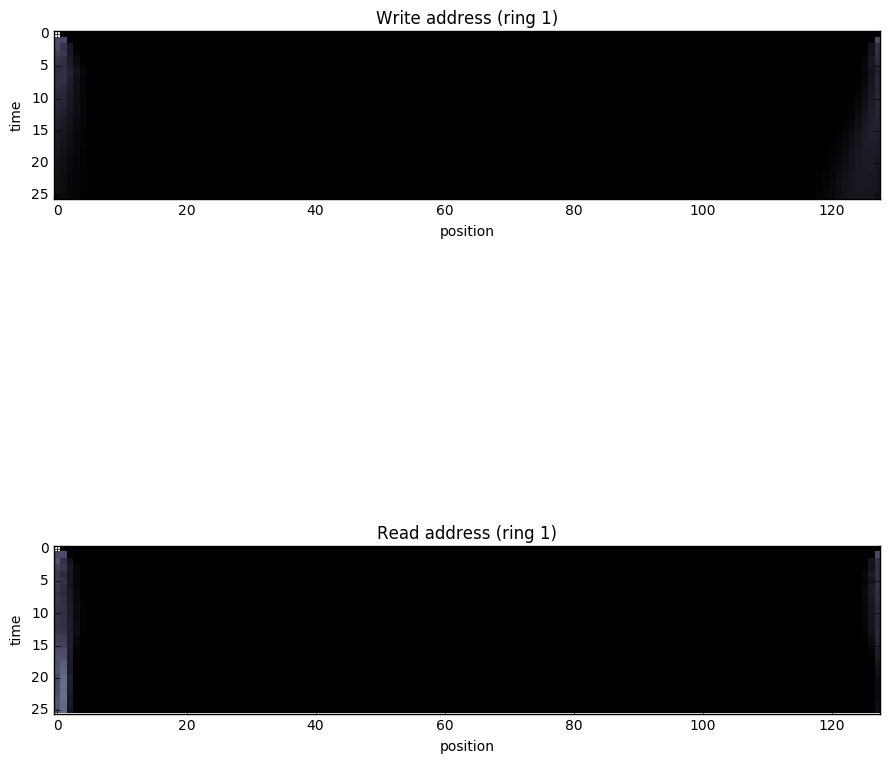

In [7]:
###########################
# VISUALISATIONS - RING 1 #
###########################

print("Sequence length used for visualisations - " + str(seq_length_for_vis))
print("Sequence used is")
print(final_seq)
print("Note: initialisation symbol is " + str(init_symbol) + " and terminal symbol is " + str(term_symbol))
print("")

pylab.rcParams['figure.figsize'] = 9, 13
fig_num = 0

# RING 1

fig_num = fig_num + 1
plt.figure(fig_num)
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)

ax1.imshow(np.stack(w1_val), cmap='bone', interpolation='nearest', aspect='equal')
ax1.set_title('Write address (ring 1)')
ax1.set_xlabel('position')
ax1.set_ylabel('time')

ax2.imshow(np.stack(r1_val), cmap='bone', interpolation='nearest', aspect='equal')
ax2.set_title('Read address (ring 1)')
ax2.set_xlabel('position')
ax2.set_ylabel('time')
plt.tight_layout()
plt.show()

In [8]:
###########################
# VISUALISATIONS - RING 2 #
###########################

if( use_model == 'pattern_ntm' or use_model == 'mult_pattern_ntm'):
    fig_num = fig_num + 1
    
    plt.figure(fig_num)
    ax1 = plt.subplot(2,1,1)
    ax2 = plt.subplot(2,1,2)

    ax1.imshow(np.stack(w2_val), cmap='bone', interpolation='nearest', aspect='equal')
    ax1.set_title('Write address (ring 2)')
    ax1.set_xlabel('position')
    ax1.set_ylabel('time')

    ax2.imshow(np.stack(r2_val), cmap='bone', interpolation='nearest', aspect='equal')
    ax2.set_title('Read address (ring 2)')
    ax2.set_xlabel('position')
    ax2.set_ylabel('time')
    plt.tight_layout()

    # Assume that powers2_on_1 has three entries we can use as colour channels
    fig_num = fig_num + 1
    plt.figure(fig_num)
    ax = plt.subplot(1,1,1)    
    ax.imshow(np.stack(m2_val), cmap='bone', interpolation='nearest', aspect='equal')
    ax.set_title('Memory contents (ring 2)')
    ax.set_xlabel('position')
    ax.set_ylabel('time')

    fig_num = fig_num + 1
    plt.figure(fig_num)
    ax = plt.subplot(1,1,1)
    
    max_xticks = 2
    xloc = plt.MaxNLocator(max_xticks)

    ax.imshow(np.stack(interps_val), cmap='bone', interpolation='nearest', aspect='auto')
    ax.set_title('Interpolation')
    ax.set_xlabel('direct vs indirect')
    ax.set_ylabel('time')
    ax.xaxis.set_major_locator(xloc)
    
    plt.tight_layout()
    plt.show()

In [9]:
################################
# VISUALISATIONS - OTHER RINGS #
################################

if( use_model == 'mult_pattern_ntm' ):
    fig_num = fig_num + 1
    
    plt.figure(fig_num)
    ax1 = plt.subplot(2,1,1)
    ax2 = plt.subplot(2,1,2)

    ax1.imshow(np.stack(w3_val), cmap='bone', interpolation='nearest', aspect='equal')
    ax1.set_title('Write address (ring 3)')
    ax1.set_xlabel('position')
    ax1.set_ylabel('time')

    ax2.imshow(np.stack(r3_val), cmap='bone', interpolation='nearest', aspect='equal')
    ax2.set_title('Read address (ring 3)')
    ax2.set_xlabel('position')
    ax2.set_ylabel('time')
    plt.tight_layout()

    fig_num = fig_num + 1
    plt.figure(fig_num)
    ax = plt.subplot(1,1,1)    
    ax.imshow(np.stack(m3_val), cmap='bone', interpolation='nearest', aspect='equal')
    ax.set_title('Memory contents (ring 3)')
    ax.set_xlabel('position')
    ax.set_ylabel('time')
    plt.tight_layout()
    
    fig_num = fig_num + 1
    
    plt.figure(fig_num)
    ax1 = plt.subplot(2,1,1)
    ax2 = plt.subplot(2,1,2)

    ax1.imshow(np.stack(w4_val), cmap='bone', interpolation='nearest', aspect='equal')
    ax1.set_title('Write address (ring 4)')
    ax1.set_xlabel('position')
    ax1.set_ylabel('time')

    ax2.imshow(np.stack(r4_val), cmap='bone', interpolation='nearest', aspect='equal')
    ax2.set_title('Read address (ring 4)')
    ax2.set_xlabel('position')
    ax2.set_ylabel('time')
    plt.tight_layout()
    plt.show()

    fig_num = fig_num + 1
    plt.figure(fig_num)
    ax6 = plt.subplot(1,1,1)    
    ax6.imshow(np.stack(m4_val), cmap='bone', interpolation='nearest', aspect='equal')
    ax6.set_title('Memory contents (ring 4)')
    ax6.set_xlabel('position')
    ax6.set_ylabel('time')
    plt.tight_layout()
    plt.show()

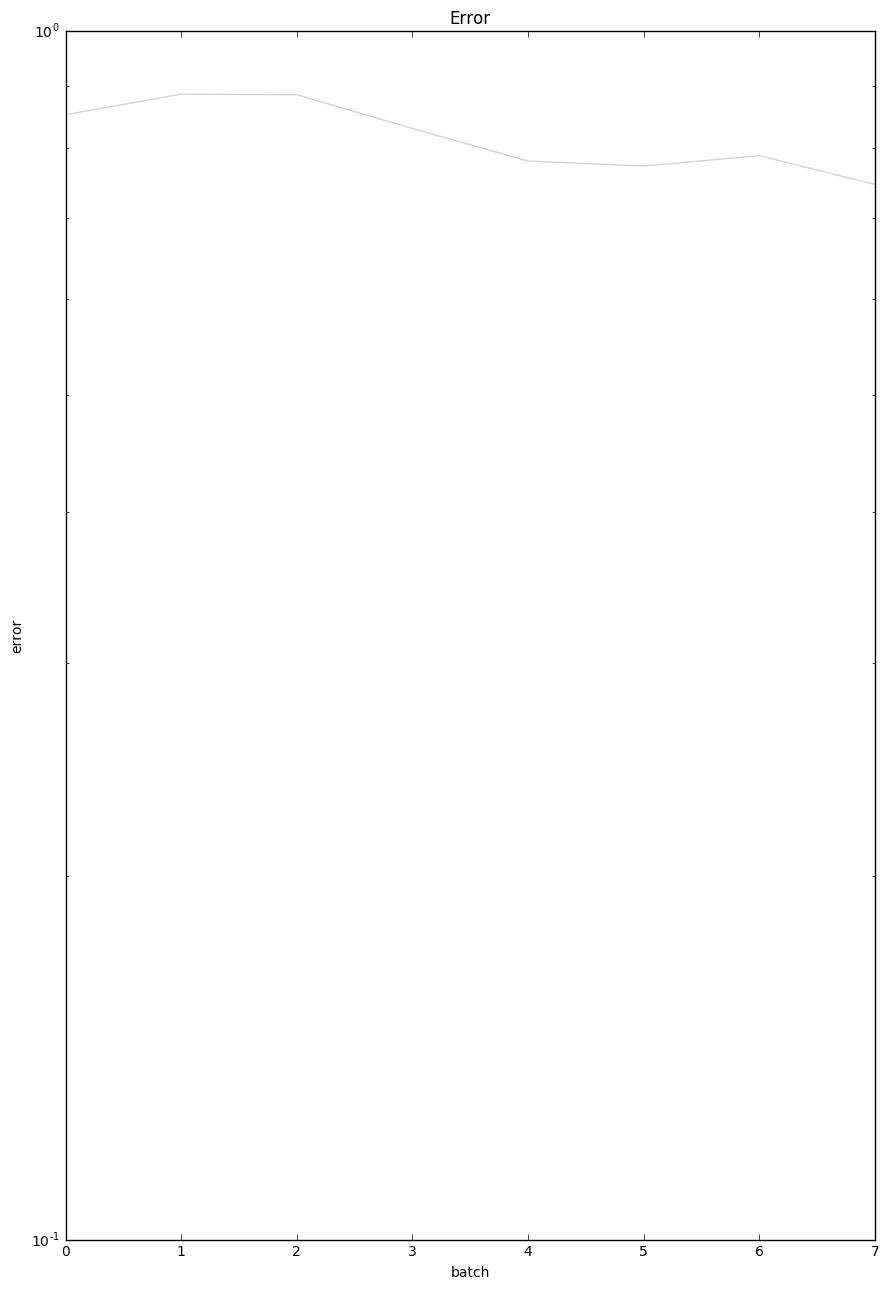

In [10]:
##########################
# VISUALISATIONS - ERROR #
##########################

fig_num = fig_num + 1

plt.figure(fig_num)
ax = plt.subplot(1,1,1)
sc = pandas.Series(error_means)
ma = sc.rolling(window=500).mean()
ax.plot(sc.index, sc, color='lightgray')
ax.plot(ma.index, ma, color='red')
ax.set_yscale('log')
ax.set_xlim(sc.index.min(), sc.index.max())
ax.set_title('Error')
ax.set_xlabel('batch')
ax.set_ylabel('error')

plt.tight_layout()
plt.show()

In [11]:
###########
# TESTING #
###########

# Restore the weights from training
sess = tf.Session()
saver.restore(sess,save_path)

inputs_test = [tf.placeholder(tf.float32, [None,input_size]) for _ in range(Ntest + Ntest_out)]
targets_test = [tf.placeholder(tf.float32, [None,input_size]) for _ in range(Ntest + Ntest_out)]

if( use_model == 'ntm' ):
    state_size, state = init_state_ntm(batch_size, controller_state_size, ntm_memory_address_size, ntm_memory_content_size)
    cell = ntm.NTM(state_size,input_size,controller_state_size,ntm_memory_address_size,ntm_memory_content_size, ntm_powers)


if( use_model == 'pattern_ntm' ):
    state_size, state = init_state_pattern_ntm(batch_size, controller_state_size, pattern_ntm_memory_address_sizes, 
                                               pattern_ntm_memory_content_sizes)
    cell = ntm.PatternNTM(state_size, input_size, controller_state_size, pattern_ntm_memory_address_sizes,
                          pattern_ntm_memory_content_sizes, pattern_ntm_powers, pattern_ntm_powers_2_on_1, pattern_ntm_direct_bias)

if( use_model == 'mult_pattern_ntm' ):
    state_size, state = init_state_pattern_ntm(batch_size, controller_state_size, mult_pattern_ntm_memory_address_sizes, 
                                               mult_pattern_ntm_memory_content_sizes)
    cell = ntm.MultPatternNTM(state_size, input_size, controller_state_size, mult_pattern_ntm_memory_address_sizes,
                          mult_pattern_ntm_memory_content_sizes, mult_pattern_ntm_powers, mult_pattern_ntm_powers_2_on_1, 
                              mult_pattern_ntm_direct_bias)
# Set up test graph
rnn_outputs_test = []
reuse = True
for i in range(Ntest + Ntest_out):
    output, state = cell(inputs_test[i],state,'NTM',reuse)
    rnn_outputs_test.append(output)

with tf.variable_scope("final_layer",reuse=True):
    E = tf.get_variable("E",[controller_state_size,input_size])
    F = tf.get_variable("F",[input_size])

logits_test = [tf.matmul(rnn_output, E) + F for rnn_output in rnn_outputs_test]
prediction_test = [tf.nn.log_softmax(logit) for logit in logits_test] 
mask = [tf.sign(tf.reduce_max(tf.abs(targets_test[i]))) for i in range(Ntest + Ntest_out)]
mistakes_test = [tf.not_equal(tf.argmax(targets_test[i], 1), tf.argmax(prediction_test[i], 1)) for i in range(Ntest + Ntest_out)]
errors_test = [tf.reduce_mean(tf.cast(m, tf.float32)) for m in mistakes_test]
errors_test_mask = [errors_test[i] * mask[i] for i in range(Ntest + Ntest_out)]
mean_error_test = tf.add_n(errors_test_mask)
mean_error_test /= tf.add_n(mask)

#### RUN TEST ####

no_of_batches = int(num_test/batch_size)

seq_length = Ntest
print("Testing on sequences of length " + str(seq_length-2))
print("")

error_means = []
for j in range(no_of_batches):
    inp = []
    out = []

    for z in range(batch_size):
        a, a_onehot, fa_onehot = io_generator(max_symbol=num_classes-3,
                                                      input_length=seq_length-2,
                                                      total_length=Ntest+Ntest_out)
            
        inp.append(a_onehot)
        out.append(fa_onehot)        
        
    feed_dict = {}
    for d in range(Ntest + Ntest_out):
        in_node = inputs_test[d]
        ti = []
        for k in range(batch_size):
            ti.append(inp[k][d])
        feed_dict[in_node] = np.array(ti)

    for d in range(Ntest + Ntest_out):
        out_node = targets_test[d]
        to = []
        for k in range(batch_size):
            to.append(out[k][d])
        feed_dict[out_node] = np.array(to)
            
    current_mean = sess.run(mean_error_test, feed_dict)
    error_means.append(current_mean)
    print("Batch - " + str(j+1) + ", Mean error - " + str(current_mean))

final_error = np.mean(error_means)

print("")        
print("###########")
print("# Summary #")
print("###########")
print("")
print("model         - " + use_model)
print("task name     - " + task)
print("epochs        - " + str(epoch))
print("num_classes   - " + str(num_classes))
print("N             - " + str(N))
print("Ntest         - " + str(Ntest))
print("# weights     - " + str(ntm.count_number_trainable_params()))
print("")
print("")
print("test error    - " + str(final_error))

sess.close()

Testing on sequences of length 13

Batch - 1, Mean error - 0.786727
Batch - 2, Mean error - 0.749636
Batch - 3, Mean error - 0.807818
Batch - 4, Mean error - 0.793455

###########
# Summary #
###########

model         - ntm
task name     - mult pattern 2
epochs        - 2
num_classes   - 10
N             - 10
Ntest         - 15
# weights     - 18958


test error    - 0.784409
